In [75]:
# import libraries
import numpy as np
import scipy as sp
from ipywidgets import interact
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline

In [76]:
# parameters used throughout the code
h = 9 # immersion depth of straw, cm
H = 20 # length of straw, cm
g = 9.8 # gravity, ms^-2
D = 0.007 # diameter of straw, m

P_atm = 1030

t_norm = (h*1e-2/g)**-0.5 #normalisation constant, 1e-2 cm to m

# Calculated using "http://www.met.reading.ac.uk/~sws04cdw/viscosity_calc.html"
# 0%, 10%, 20%, ..., 70% by volume
# all values at 23degC
rhos = [997.38, 1026.6, 1055.8, 1084.7, 1113.0,
        1140.3, 1166.6, 1191.6] # kg/m^3
etas = [0.00093505, 0.0012808, 0.0018249, 0.0027285, 0.0043309,
        0.0074104, 0.013960, 0.029822] # Ns/m^-2

In [77]:
def DZ_dt_Lor(Z, t, args):
    Omeg = args[0]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1]]

def loadData(filename):
    data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
    time_data = data[:,0]
    z_data = data[:,2]*100 # bc in m

    timeshift = time_data[0] # shifted so that t=0 is the time in video that the cap is released.
    time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
    z_data_clean = z_data[np.isfinite(z_data)]
    z_err = np.full(shape=z_data_clean.shape, fill_value=0.1)

    #z_0 = 1.954e-2 # height of liquid in straw, cm # calculated as d
    conc = int(filename[0])
    eta = etas[conc] # Ns/m^-2
    rho = rhos[conc] # kg/m^3
    omeg = 16 * eta * (h * 10**-2)**0.5 / (rho * (D/2)**2 * g**0.5)
    d = (1 - P_atm/(rho*(10**-3)*h + P_atm))*H # initial height of liquid in straw

    def func(t, factor):
        Omeg = omeg*factor
        h=9
        t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.001)
        Z_soln = sp.integrate.odeint(DZ_dt_Lor, [d, 0.00], t_solnLor, args=((Omeg,),))
        z_soln = Z_soln[:, 0]*h
        t_solnLor /= t_norm # unnormalise to compare to real 
        # find corresponding t values and the z_soln for them
        # searchsorted should be safe as the time data will all be in order
        zout = z_soln[np.searchsorted(t_solnLor, t)-1]
        return zout-h

    return time_data_clean, z_data_clean, z_err, omeg, func

# currently taking the h to be constant (which is what we set it as)
# allowing it to vary in the model is interesting but ultimately wrong
def analyse(filename, plot=False, ax=None):
    timedata, zdata, zerr, omeg, func = loadData(filename)
    P = curve_fit(func, timedata, zdata, p0=(1),  sigma=zerr, absolute_sigma=True)
    vals = P[0]
    err = np.sqrt(np.diag(P[1]))
    h = [9, 0.1]#[vals[0], err[0]]
    if plot:
        if ax is None:
            ax = plt.figure()
        #plt.scatter(timedata, zdata, label=f"{filename}")
        plt.errorbar(timedata, zdata+h[0], zerr, fmt="b.", capsize=2, label=f"{filename}")
        plt.plot(timedata[1:], func(timedata[1:], *P[0])+h[0],"g--", label="Lorenceau")
        plt.legend()
    factor = [vals[0], err[0]]
    Omeg = [vals[0]*omeg, err[0]*omeg]

    return factor, Omeg, h

def analyseAll(plots=False):
    filenames = []
    data = []
    # as with MultiSimpleFit this can be cleaned up
    # when we get 30%
    for perc in range(0, 30, 10):
        for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
            filenames.append(file)
            data.append(analyse(file, plot=plots))
    for perc in range(40, 80, 10):
        for file in [f"{perc}%V1",f"{perc}%V2",f"{perc}%V3"]:
            filenames.append(file)
            data.append(analyse(file, plot=plots))
    return np.array(filenames), np.array(data)
    
# potential fitting regimes
linear = lambda x, a, b: a*x+b # pguess = (1,1)
quadratic = lambda x, a, b, c: a*x**2+b*x+c # pguess = (1,1,1)

def plotCoeff(x, y, yerr, title_="", ylabel_="", fitter=quadratic, pguess=(1,1,1), **kwds):
    fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=pguess, 
                           sigma=yerr, absolute_sigma=True, **kwds)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, *pfit)

    #main data and model
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    ax1.set_title("Lorenceau fit, " + title_)
    ax1.set_xlabel("Conc by vol (%)")
    ax1.set_ylabel(ylabel_)

    #residuals
    xs = x
    yres = y - fitter(xs, *pfit)
    ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
    ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
    ax2.set_xlabel("Conc by vol (%)")
    ax2.set_ylabel("Residuals")

    #histogram
    ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
    ax3.hist(x=yres, bins=8, orientation="horizontal")
    
    return pfit, np.sqrt(np.diag(pcov))

def plotData(filenames, data):
    conc = np.array([int(x[0])*10 for x in filenames])
    plotCoeff(conc, data[:, 0, 0], data[:, 0, 1], "Factor", "Factor (unitless)", linear, (1,1))
    plotCoeff(conc, data[:, 1, 0], data[:, 1, 1], "Omega", "Omega (unitless), $\Omega_{derived}$ * factor", linear, (1,1))
    #plotCoeff(conc, data[:, 2, 0], data[:, 2, 1], "depth of straw submersion", "h (cm)", linear, (1,1))

In [78]:
Filenames, Data = analyseAll(False)

In [79]:
def printData(filenames, data):
    for f, d in zip(filenames, data):
        print(f"{f}: Factor: {d[0][0]} +/- {d[0][1]}\n\
            Omeg: {d[1][0]} +/- {d[1][1]}\n\
            h: {d[2][0]} +/- {d[2][1]}")
#printData(Filenames, Data)

In [80]:
# potential fitting regimes
linear = lambda x, a, b: a*x+b # pguess = (1,1)
quadratic = lambda x, a, b, c: a*x**2+b*x+c # pguess = (1,1,1)

def plotCoeff(x, y, yerr, title_="", ylabel_="", fitter=quadratic, pguess=(1,1,1), **kwds):
    fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=pguess, 
                           sigma=yerr, absolute_sigma=True, **kwds)
    xs = np.linspace(0, x[-1])
    ys = fitter(xs, *pfit)

    #main data and model
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    ax1.set_title("Lorenceau fit, " + title_)
    ax1.set_xlabel("Conc by vol (%)")
    ax1.set_ylabel(ylabel_)

    #residuals
    xs = x
    yres = y - fitter(xs, *pfit)
    ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
    ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
    ax2.set_xlabel("Conc by vol (%)")
    ax2.set_ylabel("Residuals")

    #histogram
    ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
    ax3.hist(x=yres, bins=8, orientation="horizontal")
    
    return pfit, np.sqrt(np.diag(pcov))

def plotData(filenames, data):
    conc = np.array([int(x[0])*10 for x in filenames])
    plotCoeff(conc, data[:, 0, 0], data[:, 0, 1], "Factor", "Factor (unitless)", linear, (1,1))
    plotCoeff(conc, data[:, 1, 0], data[:, 1, 1], "Omega", "Omega (unitless), $\Omega_{derived}$ * factor", linear, (1,1))



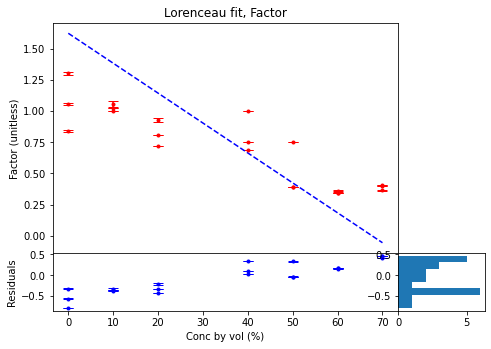

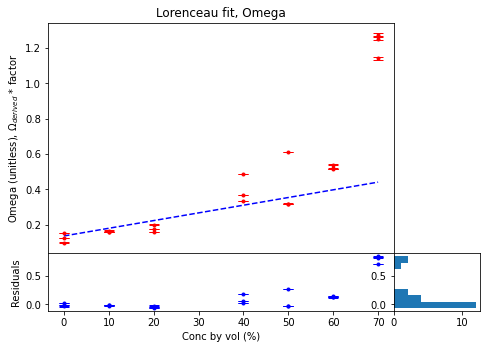

In [81]:
# both plots use linear fits and dont fit visually.
# i think this is mostly due to errorbar size on most of the values
plotData(Filenames, Data)